In [32]:
import re
import random
import pandas as pd
import hashlib

In [33]:
with open("certcards2.txt", mode="r", encoding="utf8") as f:
    all_cards = f.read()

card_split_pattern = r"\n\n\n\d+\n"
all_cards = re.split(card_split_pattern, all_cards)
# Use re.DOTALL to allow . to match newline characters
card_pattern = re.compile(r"(.+?)\n([\s\S]+)", re.DOTALL)
cards = [
    (match.group(1), match.group(2))
    for cstring in all_cards
    if (match := re.search(card_pattern, cstring))
]

# removing the cards that have no content and trimming
cards = [
    (subject, stripped_content)
    for subject, content in cards
    if len(stripped_content := content.strip()) > 5
]


def hash_string_md5(s):
    """
    Hashes a string using MD5 and returns a truncated hash for efficiency.

    Parameters:
    - s (str): The input string to hash.

    Returns:
    - str: The truncated hexadecimal hash string.
    """
    if pd.isnull(s):
        return None  # Handle NaN values gracefully
    return hashlib.md5(s.encode("utf-8")).hexdigest()


def remake_card_document(
    existing_cards: pd.DataFrame, filename: str = "certcards2.txt"
):
    with open(filename, mode="w", encoding="utf8") as f:
        i = 1
        for _, row in existing_cards.iterrows():
            f.write("\n" * 6)
            f.write(str(i) + "\n")
            f.write(row["head"] + "\n")
            f.write(row["body"])
            i += 1
    print(f"Cards found: {existing_cards.shape[0]}")
    print(f"Total card age: {abs(existing_cards['age'].sum()):.2f}")


existing_cards = pd.DataFrame(cards, columns=["head", "body"])


# existing_cards['age'] = [random.random() for _ in existing_cards.index]
existing_cards["hash"] = existing_cards["body"].apply(hash_string_md5)

card_ages = pd.read_json("card_ages.json")
card_ages = card_ages.drop_duplicates(subset=["hash"], keep="first")

cards_to_age = pd.merge(
    left=existing_cards,
    right=card_ages[["hash", "age"]],
    left_on="hash",
    right_on="hash",
    how="left",
)


cards_to_age["head"] = cards_to_age["head"].str.strip()

# remove headers I don't want anymore
undesired_headers = ["CCH Axcess"]
cards_to_age = cards_to_age.loc[~cards_to_age["head"].isin(undesired_headers), :].copy()

cards_to_age["age"] = cards_to_age["age"].fillna(0)

age_factor = 1.01
cards_to_age["age"] = cards_to_age["age"] * age_factor

cards_to_age["age"] = cards_to_age["age"] + [
    random.expovariate(0.5) for _ in cards_to_age.index
]
# cards_to_age['age'] = cards_to_age['age'] * [random.expovariate(1) for _ in cards_to_age.index]
if cards_to_age["age"].mean() > 80:
    cards_to_age["age"] = cards_to_age["age"] * [
        random.expovariate(1.3) for _ in cards_to_age.index
    ]

# Adding priority age growth to cards for upcoming certifications
priority_headers = [
    # "Django", 
    # "PnP PowerShell",
    # "Python + Oauth2.0"
    ]
priority_cards_mask = cards_to_age["head"].isin(priority_headers)
cards_to_age.loc[priority_cards_mask, "age"] = (
    cards_to_age.loc[priority_cards_mask, "age"] * 1.075
)

cards_to_age = cards_to_age.drop_duplicates(subset=["hash"], keep="first")

cards_to_age["subject_mean_age"] = cards_to_age.groupby("head")["age"].transform("mean")
cards_to_age["subject_highest_age"] = cards_to_age.groupby("head")["age"].transform(
    "max"
)
cards_to_age["subject_age_sum"] = cards_to_age.groupby("head")["age"].transform("sum")
cards_to_age["head_random_roll"] = cards_to_age.groupby("head")["head"].transform(
    lambda x: random.random()
)
cards_to_age["head_count"] = cards_to_age.groupby("head")["head"].transform("count")


cards_to_age.sort_values("hash")[["age", "head", "hash"]].to_json(
    "card_ages.json", indent=2
)

existing_cards = cards_to_age

In [34]:
ave_order = ('age', 'mean')
sum_order = ('age', 'sum')

stats = existing_cards.groupby('head').agg({'age': ['sum', 'mean', 'max'], 'head': 'count'}).sort_values(ave_order)
stats.columns = stats.columns.to_flat_index()
stats.columns = ['_'.join(col).strip() for col in stats.columns]
stats.index.name = None
stats

,age_sum,age_mean,age_max,head_count
Ubuntu,50.377452,1.937594,7.891325,26
eDiscovery,118.035276,2.185838,8.182243,54
Network Terms,137.876277,9.191752,15.615549,15
"The Mines of the Behemoth, Shea",841.230319,17.167966,32.498549,49
Exchange Online and Defender,951.120466,24.387704,41.324891,39
Docker,877.093527,28.293340,46.789254,31
SSH + SCP,907.980257,31.309664,52.880182,29
GUI Docker Container,894.961601,42.617219,64.927649,21
Linux,1397.366074,43.667690,64.957089,32
"Everything is Tuberculosis, Green",1065.733724,46.336249,68.724485,23


# Histogram

sum of ages: ~63326.84


<Axes: >

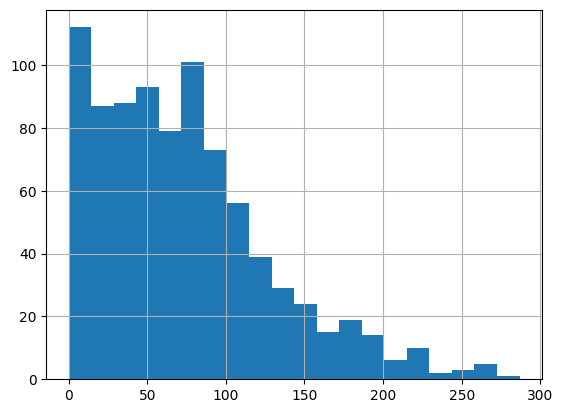

In [35]:
print(f"sum of ages: ~{existing_cards['age'].sum(0):.2f}")
existing_cards['age'].hist(bins=20)

sum of ages: ~63326.84


<Axes: >

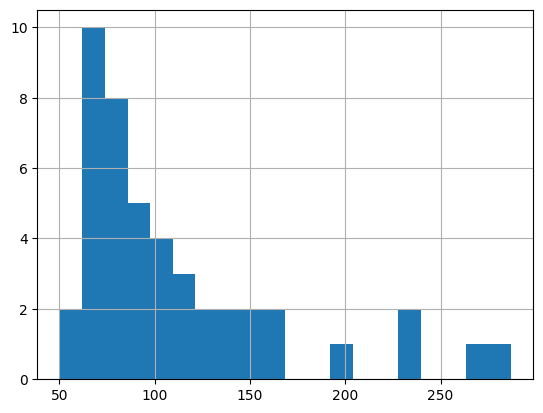

In [36]:
print(f"sum of ages: ~{existing_cards['age'].sum(0):.2f}")
existing_cards[existing_cards['head']=='Microsoft Purview']['age'].hist(bins=20)

# Completely Random Shuffle

In [37]:
# existing_cards = existing_cards.sample(frac=1)
# remake_card_document(filename='certcards2.txt', existing_cards = existing_cards)

# Age Sort

In [38]:
# existing_cards = existing_cards.sort_values('age', ascending=False)
# remake_card_document(filename='certcards2.txt', existing_cards=existing_cards)
# existing_cards.head(10)

# N-fold shuffle


## Age Sum

In [39]:
# n = 3
# m=existing_cards.shape[0]//100
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] // m

# existing_cards['subject_age_sum'] = existing_cards['subject_age_sum'] *-1
# existing_cards['age'] = existing_cards['age'] *-1
# existing_cards.sort_values(['n_fold', 'subject_age_sum', 'age'], inplace=True)

# remake_card_document(existing_cards=existing_cards)
# existing_cards.head(10)


## Age Mean

In [40]:
# n=3
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] % n

# existing_cards['subject_mean_age'] = existing_cards['subject_mean_age'] *-1
# existing_cards['age'] = existing_cards['age'] *-1
# existing_cards.sort_values(['n_fold', 'subject_mean_age', 'age'], inplace=True)
# remake_card_document(existing_cards=existing_cards)

# existing_cards.head(10)

## Age Max

In [41]:
n = random.choice([2, 3, 3, 4, 4, 5])

existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
existing_cards['n_fold'] = existing_cards['count'] // n

if existing_cards['age'].sum() > 0:
    existing_cards['subject_highest_age'] = existing_cards['subject_highest_age'] *-1
    existing_cards['neg_age'] = existing_cards['age'] *-1
existing_cards.sort_values(['n_fold', 'subject_highest_age', 'neg_age'], inplace=True)
# existing_cards.sort_values(['age'], inplace=True)

remake_card_document(existing_cards=existing_cards)
existing_cards.head(10)


Cards found: 856
Total card age: 63326.84


,head,body,hash,age,subject_mean_age,subject_highest_age,subject_age_sum,head_random_roll,head_count,count,n_fold,neg_age
0,Microsoft Purview,"You can configure your policies so that, when ...",1bc3c328bf07dac54524eadc58cfa328,286.839913,111.517456,-286.839913,5018.285519,0.418437,45,0,0,-286.839913
1,Microsoft Purview,"When you create your DLP policies, you should ...",8ec1edc0f421bb7de2884cb3c7089b3e,271.391062,111.517456,-286.839913,5018.285519,0.418437,45,1,0,-271.391062
54,Microsoft Purview,"To get started quickly, you might pick the pre...",e542e2a23a914df763b637b8b44b5d98,230.266150,111.517456,-286.839913,5018.285519,0.418437,45,2,0,-230.266150
55,Microsoft Purview,When you create your sensitivity labels in the...,b56c54e583b9557b10b4473dae3ec02a,228.692525,111.517456,-286.839913,5018.285519,0.418437,45,3,0,-228.692525
108,Microsoft Purview,DLP reports a vast amount of information to Mi...,21125699205a471834408e12af92973d,199.683327,111.517456,-286.839913,5018.285519,0.418437,45,4,0,-199.683327
4,"Mexican Gothic, Moreno-Garcia",traceries (TRAY-suh-reez)\nnoun\nDelicate orna...,3720f358b6a22134861965f53caa4c3e,267.161067,98.068148,-267.161067,2745.908141,0.755654,28,0,0,-267.161067
5,"Mexican Gothic, Moreno-Garcia",silver salver (SIL-vur SAL-vur)\nnoun\nA flat ...,25010ab30676c7df56f2d417a29190ed,186.767005,98.068148,-267.161067,2745.908141,0.755654,28,1,0,-186.767005
58,"Mexican Gothic, Moreno-Garcia","pilasters (pi-LAS-turz)\nnoun\nFlat, rectangul...",1ff17f3ef07155bb3701099a44151db6,167.785223,98.068148,-267.161067,2745.908141,0.755654,28,2,0,-167.785223
59,"Mexican Gothic, Moreno-Garcia","damask (DAM-uhsk)\nnoun\nA rich, reversible fa...",1e057ea87ce3412a763bc94760720d01,145.668463,98.068148,-267.161067,2745.908141,0.755654,28,3,0,-145.668463
112,"Mexican Gothic, Moreno-Garcia",Zapotec (ZAH-puh-tek)\nnoun\nAn Indigenous peo...,b73974c1baed60879e5f94ef7e33ca99,129.422181,98.068148,-267.161067,2745.908141,0.755654,28,4,0,-129.422181


## Card Count

In [42]:
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()

# choices = ['floor', 'mod']
# option = random.choice(choices)
# if option == 'floor':
#     n=5
#     existing_cards['n_fold'] = existing_cards['count'] // n
#     print("floor dividing for n-fold")
# elif option == 'mod':
#     n=3
#     existing_cards['n_fold'] = existing_cards['count'] % n
#     print("modulo for n-fold")
# else: raise NotImplementedError


# if existing_cards['age'].sum() > 0:
#     # existing_cards['neg_subject_highest_age'] = existing_cards['subject_highest_age'] *-1
#     existing_cards['neg_age'] = existing_cards['age'] *-1
#     existing_cards['subject_highest_age'] *= -1
# existing_cards.sort_values(['n_fold', 'head_count', 'subject_highest_age', 'neg_age'], inplace=True)
# remake_card_document(existing_cards=existing_cards)

# existing_cards.head(10)


## Random

In [43]:
# n = 3
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] % n
# existing_cards['age'] *= -1
# existing_cards.sort_values(['n_fold', 'head_random_roll', 'age'], inplace=True)
# remake_card_document(existing_cards=existing_cards)
# existing_cards.head(10)

In [44]:
existing_cards.head(10)['age'].sum()

np.float64(2113.6769144728732)

In [45]:
asc = existing_cards.age.sum() < 0

existing_cards.sort_values('age', ascending=asc).head(10)

,head,body,hash,age,subject_mean_age,subject_highest_age,subject_age_sum,head_random_roll,head_count,count,n_fold,neg_age
0,Microsoft Purview,"You can configure your policies so that, when ...",1bc3c328bf07dac54524eadc58cfa328,286.839913,111.517456,-286.839913,5018.285519,0.418437,45,0,0,-286.839913
1,Microsoft Purview,"When you create your DLP policies, you should ...",8ec1edc0f421bb7de2884cb3c7089b3e,271.391062,111.517456,-286.839913,5018.285519,0.418437,45,1,0,-271.391062
4,"Mexican Gothic, Moreno-Garcia",traceries (TRAY-suh-reez)\nnoun\nDelicate orna...,3720f358b6a22134861965f53caa4c3e,267.161067,98.068148,-267.161067,2745.908141,0.755654,28,0,0,-267.161067
2,Terraform Codebox,corepack pnpm test\nA command pattern used to ...,85012d4ed6b5e32d36886a085cc48197,264.420983,124.057581,-264.420983,4466.072901,0.041098,36,0,0,-264.420983
3,Terraform Codebox,Lifecycle blocks let you fine-tune resource be...,0f442d63063c2560ae76af631c6b9d12,263.940990,124.057581,-264.420983,4466.072901,0.041098,36,1,0,-263.940990
6,Python + Oauth2.0,authorize_url\n\nThe endpoint where the user i...,6a264f45c613880c60d7986e3d683448,259.475995,129.300589,-259.475995,2456.711187,0.103112,19,0,0,-259.475995
7,Python + Oauth2.0,"(""localhost"", 8080)\n\nThe address tuple passe...",d33808d12096e5298b1e5c8617c745a4,257.310796,129.300589,-259.475995,2456.711187,0.103112,19,1,0,-257.310796
8,Django,ALLOWED_HOSTS\nA Django setting defining which...,98abd3a22fda01e308a7bd38442e8f4c,255.433596,154.629349,-255.433596,5412.027200,0.181205,35,0,0,-255.433596
10,CCH Tax Forms Project,Disabling GenerateMeta in CCH Axcess export op...,0881e21379d3a9f0ad63b7c4f20a58f9,246.134622,116.970837,-246.134622,1988.504227,0.618827,17,0,0,-246.134622
60,Python + Oauth2.0,handler.end_headers()\n\nFinalizes the HTTP re...,91ad05cd6046d3375013aa16d642650d,242.557417,129.300589,-259.475995,2456.711187,0.103112,19,2,0,-242.557417


In [46]:
f"Average age: {abs(existing_cards['age'].mean()):.3f}"

'Average age: 73.980'